# Measuring Cell Deformation

## Imports

In [1]:
%matplotlib widget

In [2]:
#@title Imports

import copy
import pickle

import cv2
import numpy as np
from stardist.models import StarDist2D
from skimage import io, color
import pandas as pd

import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

from ipywidgets import Button, HBox, interact, IntSlider, Output
from IPython.display import display, clear_output
import ipywidgets as widgets

from skimage.morphology import opening, disk, closing
from skimage.filters import gaussian
from skimage.color import label2rgb

import pandas as pd
from skimage.measure import regionprops, regionprops_table

from sklearn.decomposition import PCA


2025-05-27 11:58:25.955984: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-27 11:58:25.957292: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-27 11:58:25.961702: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-27 11:58:25.969794: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748357905.984858   14055 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748357905.98

## Loading Data
Suppose that we have save the data using pickle by doing:

In [3]:
# # Example dictionary
# data = {
#     1: [1, 2, 3],
#     2: [4, 5, 6],
#     3: [7, 8, 9]
# }

# # Save dictionary to a pickle file
# with open('data.pkl', 'wb') as pickle_file:
#     pickle.dump(data, pickle_file)


and then, we load it like (if we want to read the .pkl of the movie number 12 and the cell that was labeled as 12 in the beggining):

In [4]:
# Load dictionary from a pickle file
#number_movie = 5
#with open(f'data_tracking_faisal/movie_{number_movie}/filtered_df_39.pkl', 'rb') as pickle_file:
#    filtered_df = pickle.load(pickle_file)

with open(f'data_tracking_expe5/Tablas video 5/Tabla 1 celula L1.pkl', 'rb') as pickle_file:
    filtered_df = pickle.load(pickle_file)
    
filtered_df

,frame,label,area,centroid-0,centroid-1,equivalent_diameter,bbox_area,convex_area,filled_area,major_axis_length,...,eccentricity,euler_number,extent,feret_diameter_max,max_intensity,mean_intensity,min_intensity,orientation,perimeter,solidity
0,0,9,972.0,718.940329,601.593621,35.179381,1260.0,1004.0,972.0,36.333234,...,0.346771,1,0.771429,37.363083,0.465306,0.382955,0.161351,-1.478548,115.154329,0.968127
1,1,10,971.0,718.749743,602.192585,35.161280,1258.0,1002.0,971.0,37.003713,...,0.428876,1,0.771860,37.854986,0.489283,0.393475,0.167195,-1.277343,115.154329,0.969062
2,2,18,930.0,718.810753,603.249462,34.410940,1221.0,959.0,930.0,36.546413,...,0.461733,1,0.761671,37.576588,0.493215,0.378472,0.154128,-1.351120,112.568542,0.969760
3,3,5,928.0,718.596983,603.915948,34.373919,1184.0,953.0,928.0,36.897272,...,0.496394,1,0.783784,38.078866,0.472077,0.375908,0.156668,-1.295642,111.740115,0.973767
4,4,65,649.0,736.587057,606.865948,28.745999,784.0,668.0,649.0,30.593691,...,0.464012,1,0.827806,32.202484,0.526313,0.375796,0.137470,0.787478,93.355339,0.971557
5,4,114,668.0,709.988024,602.299401,29.163745,870.0,693.0,668.0,32.010714,...,0.553518,1,0.767816,33.120990,0.530689,0.387083,0.141783,-0.976733,95.254834,0.963925
6,5,40,773.0,713.853816,602.763260,31.372188,1050.0,802.0,773.0,34.410321,...,0.542995,1,0.736190,35.510562,0.469734,0.379485,0.136275,-1.294211,104.325902,0.963840
7,5,100,531.0,738.847458,605.086629,26.001735,696.0,559.0,531.0,29.754228,...,0.640942,1,0.762931,30.083218,0.451687,0.353230,0.134309,-1.413189,86.183766,0.949911
8,6,104,643.0,713.516330,601.936236,28.612812,850.0,667.0,643.0,34.090798,...,0.708662,1,0.756471,35.440090,0.503108,0.406529,0.163215,1.391398,94.669048,0.964018
9,6,128,500.0,734.670000,603.438000,25.231325,700.0,549.0,500.0,30.423612,...,0.693074,1,0.714286,32.449961,0.503544,0.371087,0.125699,1.134631,89.012193,0.910747


We start analysing only one cell.

## Data Analysis
We'll start by making a new dataframe with a row for each frame and a coords column that in the union of all coordinates in the objects of that frame, effectively merging the selected objects into one. Then, we should calculate:
- the area by frame;
- PCA (we could use the variance or min/max values over these directions to get the aspect ratio of the objects).

In [5]:
# Initialize an empty list to store the aggregated data
data = []

# Group filtered_df by 'frame' and aggregate coordinates
for frame, group in filtered_df.groupby('frame'):
    # Concatenate all coords lists for the current frame into a single list
    all_coords = [coord for sublist in group['coords'] for coord in sublist]
    
    # Append the aggregated data for the current frame to the data list
    data.append({'frame': frame, 'coords': all_coords})

# Create cell_df from the aggregated data
cell_df = pd.DataFrame(data)

# Display the first few rows of cell_df to verify
cell_df

,frame,coords
0,0,"[[702, 602], [703, 596], [703, 597], [703, 598..."
1,1,"[[702, 602], [702, 603], [703, 597], [703, 598..."
2,2,"[[703, 600], [703, 601], [703, 602], [703, 603..."
3,3,"[[703, 600], [703, 601], [703, 602], [703, 603..."
4,4,"[[723, 601], [723, 602], [723, 603], [723, 604..."
5,5,"[[700, 602], [700, 603], [700, 604], [700, 605..."
6,6,"[[702, 597], [702, 598], [702, 599], [702, 600..."
7,7,"[[698, 606], [698, 607], [698, 608], [698, 609..."
8,8,"[[709, 613], [709, 614], [710, 610], [710, 611..."
9,9,"[[719, 592], [719, 593], [719, 594], [719, 595..."


In [6]:
# Ensure cell_df['coords'] lists have more than one unique point for PCA
cell_df = cell_df[cell_df['coords'].map(lambda x: len(np.unique(x, axis=0)) > 1)]

# Add a new column for centroids in cell_df
cell_df['centroid'] = cell_df['coords'].apply(lambda coords: np.mean(coords, axis=0))

# Initialize lists to store the PCA results and variance information
pc1_list = []
pc2_list = []
variance_list = []
explained_variance_ratio_list = []

# Perform PCA on the coordinates for each frame
for coords in cell_df['coords']:
    pca = PCA(n_components=2)  # Initialize PCA to find the first two principal components
    pca.fit(coords)  # Fit the PCA model to the coordinates
    
    pc1, pc2 = pca.components_  # Get the principal components
    variance = pca.explained_variance_  # Variance of each PC
    explained_variance_ratio = pca.explained_variance_ratio_  # Percentage of variance explained by each PC
    
    pc1_list.append(pc1)
    pc2_list.append(pc2)
    variance_list.append(variance)
    explained_variance_ratio_list.append(explained_variance_ratio)

# Add the PCA results and variance information to the cell_df DataFrame
cell_df['pc1'] = pc1_list
cell_df['pc2'] = pc2_list
cell_df['variance'] = variance_list
cell_df['explained_variance_ratio'] = explained_variance_ratio_list

# Display the DataFrame to verify the results
cell_df

,frame,coords,centroid,pc1,pc2,variance,explained_variance_ratio
0,0,"[[702, 602], [703, 596], [703, 597], [703, 598...","[718.940329218107, 601.593621399177]","[-0.09211772707896718, 0.995748122949677]","[0.995748122949677, 0.09211772707896718]","[82.59146546704467, 72.65984199674857]","[0.5319856355239143, 0.4680143644760857]"
1,1,"[[702, 602], [702, 603], [703, 597], [703, 598...","[718.7497425334707, 602.1925849639547]","[-0.28925972718870185, 0.9572506517243631]","[0.9572506517243631, 0.28925972718870185]","[85.66790032036731, 69.91062962535526]","[0.550640890810928, 0.44935910918907207]"
2,2,"[[703, 600], [703, 601], [703, 602], [703, 603...","[718.810752688172, 603.2494623655914]","[-0.2179139176792219, 0.9759679935744272]","[0.9759679935744272, 0.2179139176792219]","[83.56737425182975, 65.75105115651922]","[0.5596588232382819, 0.4403411767617182]"
3,3,"[[703, 600], [703, 601], [703, 602], [703, 603...","[718.5969827586207, 603.9159482758621]","[-0.2716951221963699, 0.9623833750510756]","[0.9623833750510756, 0.2716951221963699]","[85.17983013272404, 64.19095251800184]","[0.5702576408928665, 0.4297423591071336]"
4,4,"[[723, 601], [723, 602], [723, 603], [723, 604...","[723.0956719817767, 604.5497342444951]","[0.9863354234216, 0.16474960547367917]","[-0.16474960547367917, 0.9863354234216]","[233.19588267399627, 55.53811256714786]","[0.8076495546679091, 0.1923504453320908]"
5,5,"[[700, 602], [700, 603], [700, 604], [700, 605...","[724.0314417177914, 603.7093558282209]","[0.9975260036825796, 0.0702984493218903]","[-0.0702984493218903, 0.9975260036825796]","[196.99290691454846, 65.914657742788]","[0.7492858076233043, 0.2507141923766956]"
6,6,"[[702, 597], [702, 598], [702, 599], [702, 600...","[722.7699037620298, 602.5931758530184]","[0.9828012541840755, 0.18466644192762263]","[-0.18466644192762263, 0.9828012541840755]","[149.5839969328291, 60.9329132781273]","[0.7105557305725836, 0.2894442694274164]"
7,7,"[[698, 606], [698, 607], [698, 608], [698, 609...","[719.1773897058823, 609.1204044117648]","[0.9841042593486862, 0.177591685424104]","[-0.177591685424104, 0.9841042593486862]","[172.35423876122115, 55.96038019815745]","[0.754897954177372, 0.24510204582262793]"
8,8,"[[709, 613], [709, 614], [710, 610], [710, 611...","[729.4011111111112, 612.0]","[0.8479125785405359, -0.5301360760717382]","[0.5301360760717382, 0.8479125785405359]","[135.93502056672975, 39.56241979905257]","[0.774569818701662, 0.225430181298338]"
9,9,"[[719, 592], [719, 593], [719, 594], [719, 595...","[734.7443890274315, 600.709476309227]","[0.8719747133381518, 0.48955091594117983]","[-0.48955091594117983, 0.8719747133381518]","[88.47729794022156, 47.12808000065107]","[0.6524615710949155, 0.3475384289050844]"


In [7]:
cell_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   frame                     15 non-null     int64 
 1   coords                    15 non-null     object
 2   centroid                  15 non-null     object
 3   pc1                       15 non-null     object
 4   pc2                       15 non-null     object
 5   variance                  15 non-null     object
 6   explained_variance_ratio  15 non-null     object
dtypes: int64(1), object(6)
memory usage: 972.0+ bytes


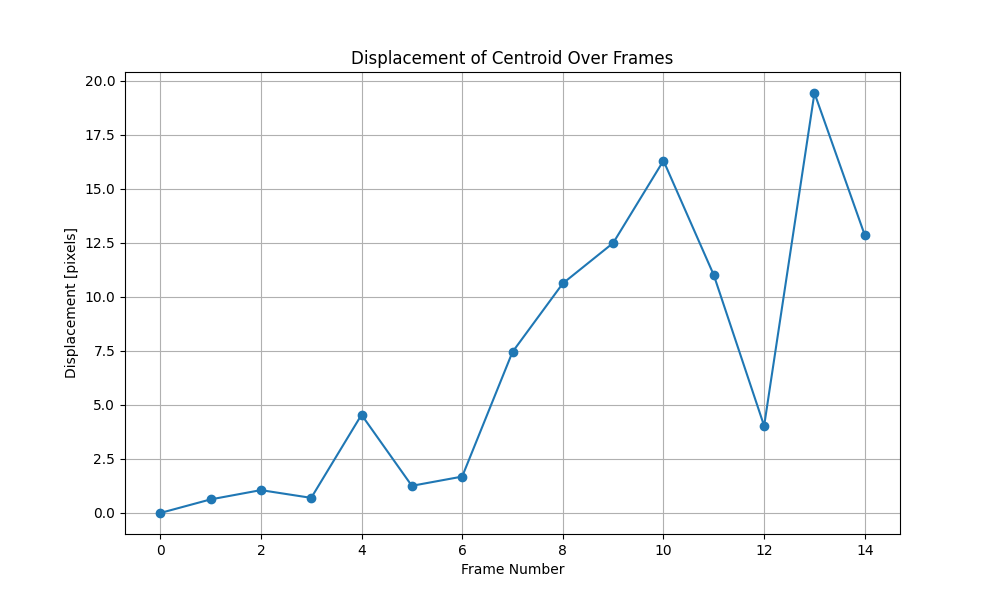

In [8]:
# Let's plot the displacement to give an idea of speed

# Calculate displacements
displacements = [0]  # The displacement for the first frame is 0 by definition
for i in range(1, len(cell_df)):
    # Calculate the Euclidean distance between consecutive centroids
    displacement = np.linalg.norm(cell_df['centroid'].iloc[i] - cell_df['centroid'].iloc[i-1])
    displacements.append(displacement)

# Add the displacements to the cell_df DataFrame
cell_df['displacement'] = displacements

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(cell_df['frame'], cell_df['displacement'], marker='o', linestyle='-')
plt.title('Displacement of Centroid Over Frames')
plt.xlabel('Frame Number')
plt.ylabel('Displacement [pixels]')
plt.grid(True)
plt.show()


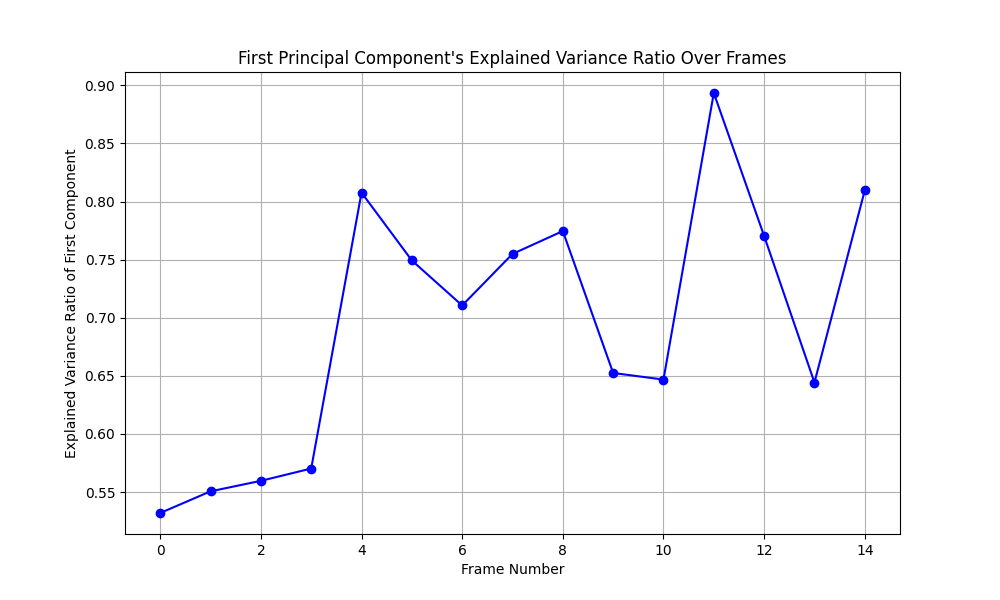

In [9]:
# Extract the first component of the explained_variance_ratio for each frame
# to give an idea of cell deformation

first_component_variance_ratio = [ratio[0] for ratio in cell_df['explained_variance_ratio']]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(cell_df['frame'], first_component_variance_ratio, marker='o', linestyle='-', color='blue')
plt.title('First Principal Component\'s Explained Variance Ratio Over Frames')
plt.xlabel('Frame Number')
plt.ylabel('Explained Variance Ratio of First Component')
plt.grid(True)
plt.show()


###  Statistical Analysis
Basic statistical analysis such as calculating the mean, standard deviation, and identifying peaks can provide additional characteristics of the displacement curve. It's not very interesting to do this directly on the displacement curve, but this example should enable you to explore things like identifying peaks in the PSD, or even in the PSD of a moving averaged version of the curve.


Mean Displacement: 6.9372257554808865
Standard Deviation: 6.193592509666405
Number of Peaks: 4


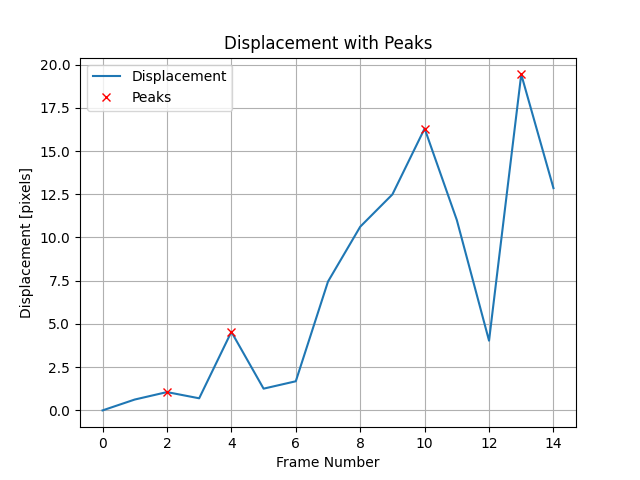

In [10]:
from scipy.signal import find_peaks

# Assume `displacement` is your displacement array and `frame_numbers` is the array of frame numbers
displacement = cell_df['displacement'].values
frame_numbers = cell_df['frame'].values

# Calculate basic statistics
mean_displacement = np.mean(displacement)
std_displacement = np.std(displacement)
peaks, _ = find_peaks(displacement)

# Print statistics
print(f"Mean Displacement: {mean_displacement}")
print(f"Standard Deviation: {std_displacement}")
print(f"Number of Peaks: {len(peaks)}")

# Plot displacement with peaks
plt.figure()
plt.plot(frame_numbers, displacement, label='Displacement')
plt.plot(frame_numbers[peaks], displacement[peaks], 'rx', label='Peaks')
plt.title("Displacement with Peaks")
plt.xlabel("Frame Number")
plt.ylabel("Displacement [pixels]")
plt.legend()
plt.grid()
plt.show()

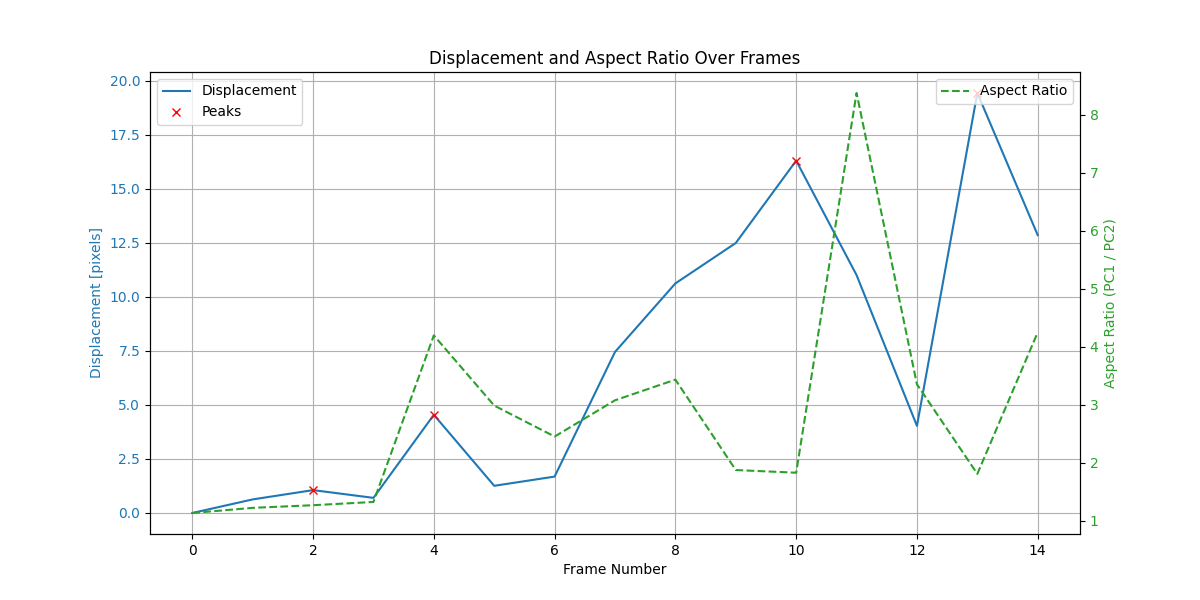

In [11]:
# Obtain the aspect ratio with the explained_variance_ratio
aspect_ratios = [ratio[0]/ratio[1] for ratio in cell_df['explained_variance_ratio']]

# Create the figure
fig, ax1 = plt.subplots(figsize=(12, 6))

# 1st y-axis: displacement
color1 = 'tab:blue'
ax1.set_xlabel('Frame Number')
ax1.set_ylabel('Displacement [pixels]', color=color1)
ax1.plot(frame_numbers, displacement, color=color1, label='Displacement')
ax1.plot(frame_numbers[peaks], displacement[peaks], 'rx', label='Peaks')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.legend(loc='upper left')

# 1st y-axis: aspect_ratio
ax2 = ax1.twinx()  # share x
color2 = 'tab:green'
ax2.set_ylabel('Aspect Ratio (PC1 / PC2)', color=color2)
ax2.plot(frame_numbers, aspect_ratios, color=color2, linestyle='--', label='Aspect Ratio')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.legend(loc='upper right')

plt.title('Displacement and Aspect Ratio Over Frames')
ax1.grid(True)

plt.show()


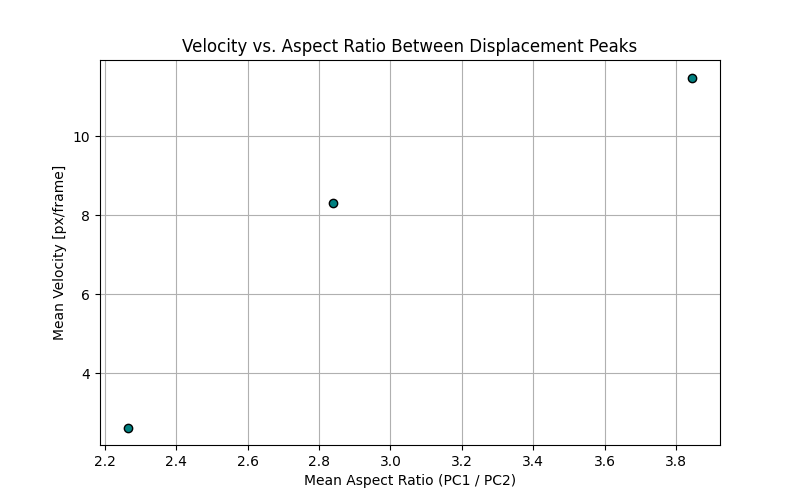

In [12]:
# Initialize lists
mean_velocities = []
mean_aspect_ratios = []

# Calculate mean velocity and mean aspect ratio between consecutive peaks
for i in range(len(peaks) - 1):
    start = peaks[i]
    end = peaks[i + 1]
    
    # Number of frames between peaks
    delta_t = frame_numbers[end] - frame_numbers[start]
    
    if delta_t == 0:
        continue

    # Total displazement in that interval
    total_disp = np.sum(displacement[start+1:end+1])
    
    # Mean velocity
    mean_velocity = total_disp / delta_t
    mean_velocities.append(mean_velocity) # we save it in the list

    # mean aspect ratio in that interval
    mean_aspect = np.mean(aspect_ratios[start:end+1])
    mean_aspect_ratios.append(mean_aspect)

# Plot mean velocity vs mean aspect ratio
plt.figure(figsize=(8, 5))
plt.scatter(mean_aspect_ratios, mean_velocities, c='teal', edgecolors='k')
plt.xlabel("Mean Aspect Ratio (PC1 / PC2)")
plt.ylabel("Mean Velocity [px/frame]")
plt.title("Velocity vs. Aspect Ratio Between Displacement Peaks")
plt.grid(True)
plt.show()


This last graph can be done using the information about all the cells we tracked.

In [13]:
import os

# Folder where the .pkl are
folder_path = f'data_tracking_expe5/Tablas video 5'

# Create a dict to save every DF
dfs = {}

# Read every .pkl and save in the dict with it name
for filename in os.listdir(folder_path):
    # Read every file finished with .pkl
    if filename.endswith('.pkl'):
        # Join the folder path with the filename (to have smth like 'data_tracking_faisal/filtered_df_39.pkl'
        filepath = os.path.join(folder_path, filename)
        # Open and load the file
        with open(filepath, 'rb') as f:
            df = pickle.load(f)
        # We use the name of the file to use it like the key
        key = os.path.splitext(filename)[0]
        dfs[key] = df


In [14]:
# Now dfs is a dictionary that have the name of the file we want to study as a key and all the description of the tracking as items.
# If we want to get one specific DataFrame (e. g. 39):
#df_39 = dfs['filtered_df_39']
#print(df_39.head())

Now we can calculate the Velocity vs. Aspect Ratio Between Displacement Peaks for each cell and plot everything in the same graph.

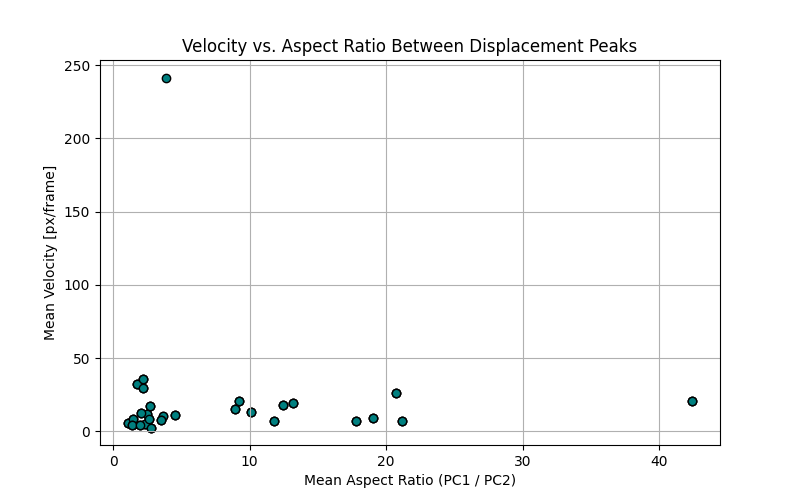

In [15]:
# Initialize lists
mean_velocities = []
mean_aspect_ratios = []


for key, filtered_df in dfs.items():
    # Initialize an empty list to store the aggregated data
    data = []
    
    # Group filtered_df by 'frame' and aggregate coordinates
    for frame, group in filtered_df.groupby('frame'):
        # Concatenate all coords lists for the current frame into a single list
        all_coords = [coord for sublist in group['coords'] for coord in sublist]
        
        # Append the aggregated data for the current frame to the data list
        data.append({'frame': frame, 'coords': all_coords})
    
    # Create cell_df from the aggregated data
    cell_df = pd.DataFrame(data)

    # Ensure cell_df['coords'] lists have more than one unique point for PCA
    cell_df = cell_df[cell_df['coords'].map(lambda x: len(np.unique(x, axis=0)) > 1)]
    
    # Add a new column for centroids in cell_df
    cell_df['centroid'] = cell_df['coords'].apply(lambda coords: np.mean(coords, axis=0))

    # Initialize lists to store the PCA results and variance information
    pc1_list = []
    pc2_list = []
    variance_list = []
    explained_variance_ratio_list = []
    
    # Perform PCA on the coordinates for each frame
    for coords in cell_df['coords']:
        pca = PCA(n_components=2)  # Initialize PCA to find the first two principal components
        pca.fit(coords)  # Fit the PCA model to the coordinates
        
        pc1, pc2 = pca.components_  # Get the principal components
        variance = pca.explained_variance_  # Variance of each PC
        explained_variance_ratio = pca.explained_variance_ratio_  # Percentage of variance explained by each PC
        
        pc1_list.append(pc1)
        pc2_list.append(pc2)
        variance_list.append(variance)
        explained_variance_ratio_list.append(explained_variance_ratio)
    
    # Add the PCA results and variance information to the cell_df DataFrame
    cell_df['pc1'] = pc1_list
    cell_df['pc2'] = pc2_list
    cell_df['variance'] = variance_list
    cell_df['explained_variance_ratio'] = explained_variance_ratio_list
    
    # Calculate displacements
    displacements = [0]  # The displacement for the first frame is 0 by definition
    for i in range(1, len(cell_df)):
        # Calculate the Euclidean distance between consecutive centroids
        displacement = np.linalg.norm(cell_df['centroid'].iloc[i] - cell_df['centroid'].iloc[i-1])
        displacements.append(displacement)
    
    # Add the displacements to the cell_df DataFrame
    cell_df['displacement'] = displacements

    # Assume `displacement` is your displacement array and `frame_numbers` is the array of frame numbers
    displacement = cell_df['displacement'].values
    frame_numbers = cell_df['frame'].values
    
    # Calculate basic statistics
    mean_displacement = np.mean(displacement)
    std_displacement = np.std(displacement)
    peaks, _ = find_peaks(displacement)
    # Obtain the aspect ratio
    aspect_ratios = [ratio[0]/ratio[1] for ratio in cell_df['explained_variance_ratio']]


    # Calculate mean velocity and mean aspect ratio between consecutive peaks
    for i in range(len(peaks) - 1):
        start = peaks[i]
        end = peaks[i + 1]
        
        # Number of frames between peaks
        delta_t = frame_numbers[end] - frame_numbers[start]
        
        if delta_t == 0:
            continue
    
        # Total displazement in that interval
        total_disp = np.sum(displacement[start+1:end+1])
        
        # Mean velocity
        mean_velocity = total_disp / delta_t
        mean_velocities.append(mean_velocity) # we save it in the list
        
        # mean aspect ratio in that interval
        mean_aspect = np.mean(aspect_ratios[start+1:end+1])
        mean_aspect_ratios.append(mean_aspect)

# Plot mean velocity vs mean aspect ratio
plt.figure(figsize=(8, 5))
plt.scatter(mean_aspect_ratios, mean_velocities, c='teal', edgecolors='k')
plt.xlabel("Mean Aspect Ratio (PC1 / PC2)")
plt.ylabel("Mean Velocity [px/frame]")
plt.title("Velocity vs. Aspect Ratio Between Displacement Peaks")
plt.grid(True)
plt.show()


In [16]:
from scipy.stats import pearsonr

# Calculate the pearson coeficient

r, p_value = pearsonr(mean_aspect_ratios, mean_velocities)

print(f"Coeficiente de Pearson: {r}")
print(f"Valor p: {p_value}")


Coeficiente de Pearson: 0.0019920958798346367
Valor p: 0.9856513774944908


Also note that we can calculate the mean aspect ratio, the mean velocity, the mean maximum velocity and the mean maximum aspect ratio...

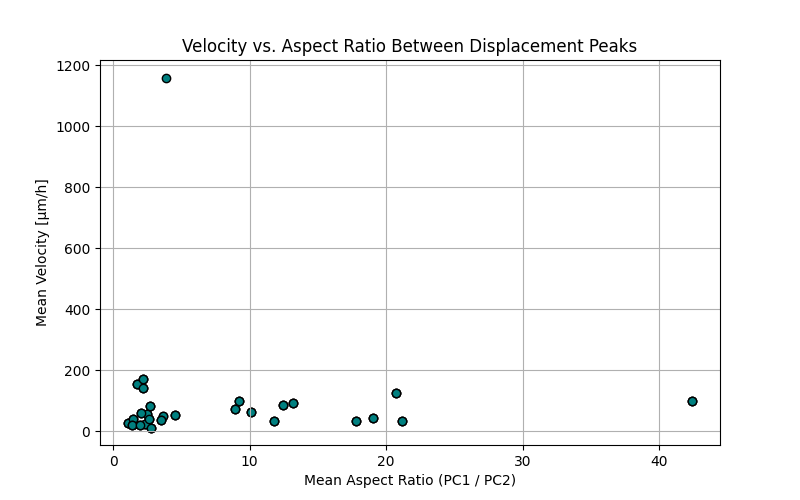

In [21]:
mean_velocities_unidades = np.array(mean_velocities)*(0.4*(60/5))
#mean_velocities_unidades = np.array(mean_velocities)*(900/(1024*3))
# Plot mean velocity vs mean aspect ratio
plt.figure(figsize=(8, 5))
plt.scatter(mean_aspect_ratios, mean_velocities_unidades, c='teal', edgecolors='k')
plt.xlabel("Mean Aspect Ratio (PC1 / PC2)")
plt.ylabel("Mean Velocity [μm/h]")
plt.title("Velocity vs. Aspect Ratio Between Displacement Peaks")
plt.grid(True)
plt.show()


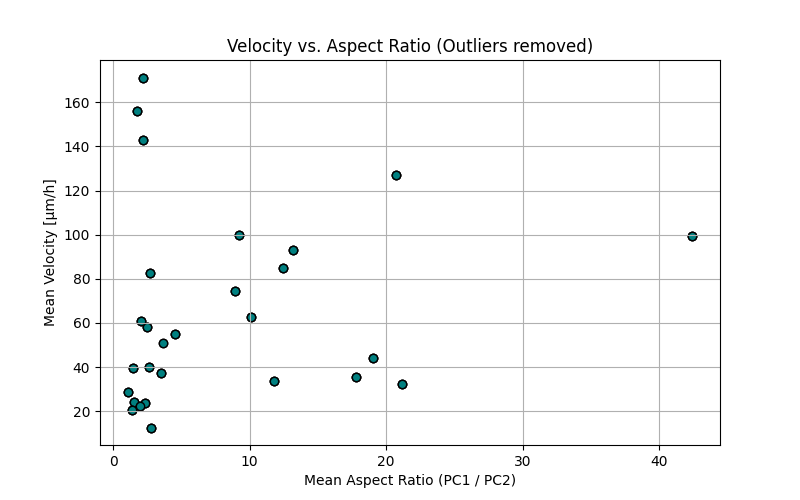

In [22]:
# Podemos eliminar los outliers

# Convertir listas a arrays
velocities = np.array(mean_velocities_unidades)
aspects = np.array(mean_aspect_ratios)

# Detectar outliers en velocidad con IQR
q1, q3 = np.percentile(velocities, [25, 75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filtrar
mask = (velocities >= lower_bound) & (velocities <= upper_bound)
filtered_velocities = velocities[mask]
filtered_aspects = aspects[mask]

# Graficar sin outliers
plt.figure(figsize=(8, 5))
plt.scatter(filtered_aspects, filtered_velocities, c='teal', edgecolors='k')
plt.xlabel("Mean Aspect Ratio (PC1 / PC2)")
plt.ylabel("Mean Velocity [μm/h]")
plt.title("Velocity vs. Aspect Ratio (Outliers removed)")
plt.grid(True)
plt.show()

In [23]:
from scipy.stats import pearsonr

# Calculate the pearson coeficient

r, p_value = pearsonr(filtered_aspects, filtered_velocities)

print(f"Coeficiente de Pearson: {r}")
print(f"Valor p: {p_value}")

Coeficiente de Pearson: 0.14651411385541646
Valor p: 0.18626508600719446


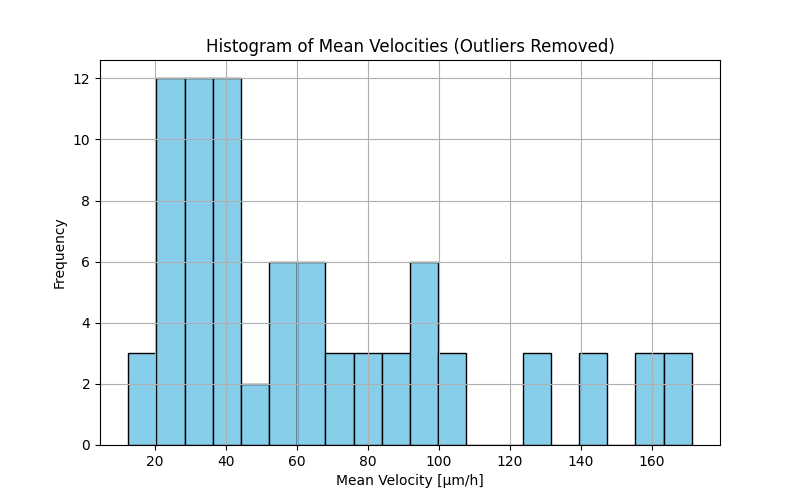

Mean velocity: 64.92 μm/h
Median velocity: 55.15 μm/h
Std deviation: 42.71 μm/h


In [27]:
plt.figure(figsize=(8, 5))
plt.hist(filtered_velocities, bins=20, color='skyblue', edgecolor='k')
plt.xlabel("Mean Velocity [μm/h]")
plt.ylabel("Frequency")
plt.title("Histogram of Mean Velocities (Outliers Removed)")
plt.grid(True)
plt.show()

mean_v = np.mean(filtered_velocities)
median_v = np.median(filtered_velocities)
std_v = np.std(filtered_velocities)

print(f"Mean velocity: {mean_v:.2f} μm/h")
print(f"Median velocity: {median_v:.2f} μm/h")
print(f"Std deviation: {std_v:.2f} μm/h")


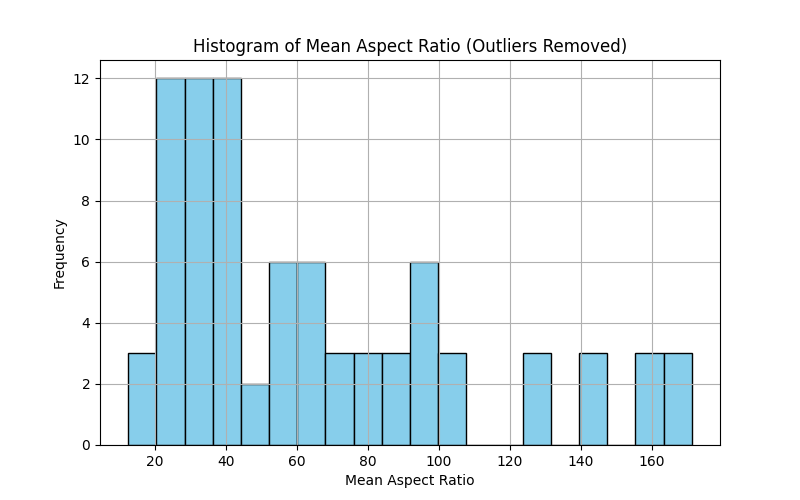

Mean aspect ratio: 8.15
Median aspect ratio: 2.76
Std deviation: 9.21


In [29]:
plt.figure(figsize=(8, 5))
plt.hist(filtered_velocities, bins=20, color='skyblue', edgecolor='k')
plt.xlabel("Mean Aspect Ratio")
plt.ylabel("Frequency")
plt.title("Histogram of Mean Aspect Ratio (Outliers Removed)")
plt.grid(True)
plt.show()

mean_ar = np.mean(filtered_aspects)
median_ar = np.median(filtered_aspects)
std_ar = np.std(filtered_aspects)

print(f"Mean aspect ratio: {mean_ar:.2f}")
print(f"Median aspect ratio: {median_ar:.2f}")
print(f"Std deviation: {std_ar:.2f}")
